In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
train = pd.read_csv("train.csv")

train.head()
print(train.shape)

(8693, 14)


# Feature Engineering

In [3]:
# Drop passenger id
train.drop('PassengerId', axis=1, inplace=True)

In [4]:
# Cabin consists of deck/num/side. Let us derive those values, and drop the cabin feature
cabin_train = train['Cabin'].str.split("/", n=2, expand=True)

train['deck'] = cabin_train[0]
train['num'] = cabin_train[1]
train['side'] = cabin_train[2]

In [5]:
train.drop('Cabin', axis=1, inplace=True)

In [6]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,deck,num,side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Name          8493 non-null   object 
 11  Transported   8693 non-null   bool   
 12  deck          8494 non-null   object 
 13  num           8494 non-null   object 
 14  side          8494 non-null   object 
dtypes: bool(1), float64(6), object(8)
memory usage: 959.4+ KB


In [8]:
train['Age'].describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [9]:
# We can bucket the Age in groups of 10s
bins= [0,10,20,30,40,50,60,70,80,90]
labels = ['1s','10s','20s','30s','40s','50s','60s','70s','80s']

train['AgeGroup'] = pd.cut(train['Age'], bins=bins, labels=labels, right=False)

In [10]:
# Drop the Age column
train.drop('Age', axis=1, inplace=True)

In [11]:
# Drop the Name column as it does not add any value to our model
train.drop('Name', axis=1, inplace=True)

In [12]:
# Replace bool values with 0-false, 1-true

col = ["CryoSleep","VIP"]

for i in col:
  train[i] = train[i].apply(lambda x:1 if x == True else 0)

In [13]:
train.Transported=train.Transported.apply(lambda x: 1 if x == True else 0)
train.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,AgeGroup
0,Europa,0,TRAPPIST-1e,0,0.0,0.0,0.0,0.0,0.0,0,B,0,P,30s
1,Earth,0,TRAPPIST-1e,0,109.0,9.0,25.0,549.0,44.0,1,F,0,S,20s
2,Europa,0,TRAPPIST-1e,1,43.0,3576.0,0.0,6715.0,49.0,0,A,0,S,50s
3,Europa,0,TRAPPIST-1e,0,0.0,1283.0,371.0,3329.0,193.0,0,A,0,S,30s
4,Earth,0,TRAPPIST-1e,0,303.0,70.0,151.0,565.0,2.0,1,F,1,S,10s


In [14]:
# For categorical features- HomePlanet, Destination, group, deck, num, side, AgeGroup, let us replace the null values with the mode
null_cols_cat = ['HomePlanet', 'Destination', 'deck', 'num', 'side', 'AgeGroup']

for col in null_cols_cat:
  train[col].fillna(train[col].mode()[0], inplace=True)

In [15]:
# For numerical features- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, replace the null values with the median
null_cols_num = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in null_cols_num:
  train[col].fillna(train[col].median(), inplace=True)

In [16]:
# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for col in null_cols_cat:
    train[col] = label_encoder.fit_transform(train[col])

# Model Building

In [17]:
# Model evaluation
from sklearn import metrics

def model_metrics(prediction, model):

  # Model Accuracy, how often is the classifier correct?
  print(f"{model} Accuracy:",metrics.accuracy_score(y_test, prediction))
  print("\n")

  # confusion matrix
  cm= metrics.confusion_matrix(y_test, prediction)
  cm_dis = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  cm_dis.plot()
  plt.show()

  classx= metrics.classification_report(y_test, prediction)
  print("\n")
  print(f"{model} Classification Report:\n", classx)

In [18]:
X = train.drop('Transported', axis=1)
y = train['Transported']

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# Model using the best random forest parameters
rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 500, max_depth=8, criterion='entropy')
rfc1.fit(X_train, y_train)

y_pred_rf_best=rfc1.predict(X_test)

Grid Searched Random Forest Accuracy: 0.7891104294478528




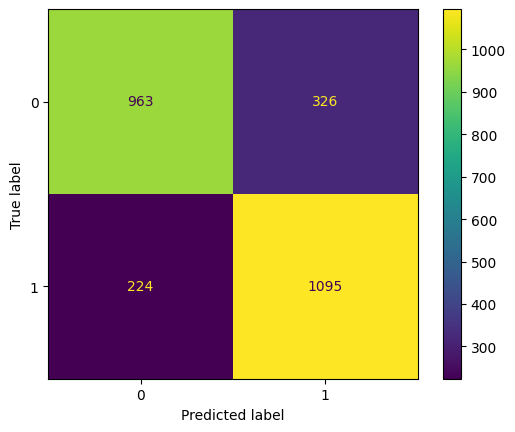



Grid Searched Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.75      0.78      1289
           1       0.77      0.83      0.80      1319

    accuracy                           0.79      2608
   macro avg       0.79      0.79      0.79      2608
weighted avg       0.79      0.79      0.79      2608



In [23]:
# Model evaluation
model_metrics(y_pred_rf_best, 'Grid Searched Random Forest')

In [30]:
def predict(HomePlanet=0,
            CryoSleep=0,
            Destination=0,
            VIP=0,
            RoomService=0,
            FoodCourt=0,
            ShoppingMall=0,
            Spa=0,
            VRDeck=0,
            deck=0,
            num=0,
            side=0,
            AgeGroup=0):
  new_test_array = np.array([[2,0,2,0,500.0,359.0,333.0,3.0,1000.0,5,1200,1,1]])
  new_test_df = pd.DataFrame(new_test_array, columns=['HomePlanet',	'CryoSleep',	'Destination',	'VIP',	'RoomService'	,'FoodCourt'	,'ShoppingMall',	'Spa',	'VRDeck',	'deck',	'num'	,'side',	'AgeGroup'])
  print(f"Dataframe created is: {new_test_df}")

  transported = rfc1.predict(new_test_df)[0]
  print(f"Prediction from rfc is: {transported}")

  if transported == 1:
    return f"The passenger was transported"
  else:
    return f"The passenger was not transported"


In [26]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size

In [ ]:
import gradio as gr
import numpy as np
import pandas as pd

with gr.Blocks() as demo:
  HomePlanet = gr.Number(label="HomePlanet")
  CryoSleep = gr.Number(label="CryoSleep")
  Destination = gr.Number(label="Destination")
  VIP = gr.Number(label="VIP")
  RoomService = gr.Number(label="RoomService")
  FoodCourt = gr.Number(label="FoodCourt")
  ShoppingMall = gr.Number(label="ShoppingMall")
  Spa = gr.Number(label="Spa")
  VRDeck = gr.Number(label="VRDeck")
  deck = gr.Number(label="deck")
  num = gr.Number(label="num")
  side = gr.Number(label="side")
  AgeGroup = gr.Number(label="AgeGroup")

  with gr.Row():
    predict_btn = gr.Button("Predict")

  prediction = gr.Textbox(label="Was the passenger transported?", interactive=False)

  predict_btn.click(predict, inputs=[HomePlanet, CryoSleep,	Destination,	VIP,	RoomService	,FoodCourt	,ShoppingMall,	Spa,	VRDeck,	deck,	num	,side,	AgeGroup], outputs= [prediction])

demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://7b0be1b7337cefa47b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Dataframe created is:    HomePlanet  CryoSleep  Destination  VIP  RoomService  FoodCourt  \
0         2.0        0.0          2.0  0.0        500.0      359.0   

   ShoppingMall  Spa  VRDeck  deck     num  side  AgeGroup  
0         333.0  3.0  1000.0   5.0  1200.0   1.0       1.0  
Prediction from rfc is: 0
Dataframe created is:    HomePlanet  CryoSleep  Destination  VIP  RoomService  FoodCourt  \
0         2.0        0.0          2.0  0.0        500.0      359.0   

   ShoppingMall  Spa  VRDeck  deck     num  side  AgeGroup  
0         333.0  3.0  1000.0   5.0  1200.0   1.0       1.0  
Prediction from rfc is: 0
Dataframe created is:    HomePlanet  CryoSleep  Destination  VIP  RoomService  FoodCourt  \
0         2.0        0.0          2.0  0.0        500.0      359.0   

   ShoppingMall  Spa  VRDeck  deck     num  side  AgeGroup  
0         333.0  3.0  1000.0   5.0  1200.0   1.0       1.0  
Prediction from rfc is: 0
